# Classification project - Modeling public trust in politicians

Zofia Broszczak (446277) and Anna Lorenz (429840)

Data Science and Business Analytics

# 1. Introduction

This project contributes directly to Zofia Broszczak’s Master’s Degree thesis. 

The main objective is to examine what individual characteristics and social factors are the strongest predictors of trust in politicians. 

The data used in this project come from the European Social Survey (ESS) (European Social Survey, 2025). There have so far been 11 rounds of the European Social Survey done. In order to make the analysis interesting and advanced, we rely on a dataset constructed by concatenating data from ESS Rounds 1 through 11 (https://ess.sikt.no/en/). The preprocessing and combining the datasets from each round to create one final dataset used for modeling is done in the "2. Data description and preparation" section.

The dependent variable is "Trust in politicians". Public trust in politicians is shaped by a broad set of determinants, ranging from demographic and economic conditions to political attitudes and social values. 

There are around 600 variables in each ESS data round and each round has variables that are unique and do not exist in other rounds. Since harmonization of such datasets would require extensive manual labour, we choose only a subset of variables as the features in our models based on reviewing the existing literature on this topic. The chosen variables capture a wide range of respondent characteristics, including socio-demographic attributes, political attitude and human value variables as well as national and ethnic identity variables. This can be found in section "2.3. Literature review and feature selection". 

Overall, the project aims to identify the factors that most strongly shape perceptions of trust in politicians. In addition, it evaluates how effectively tree-based and ensemble machine learning methods capture the complex relationships between individual characteristics and levels of political trust.

### Libraries

In [1]:
import warnings

from pathlib import Path
import pyreadstat
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     StratifiedKFold, RandomizedSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             classification_report, balanced_accuracy_score, 
                             accuracy_score, precision_recall_fscore_support)

warnings.filterwarnings("ignore")

# 2. Data description and preparation

## 2.1 Data sources and metadata extraction (CSV and SPSS)

In this project, the main analysis dataset is built from CSV exports of 11 ESS rounds, while the corresponding SPSS files are used to extract variable labels and value labels. These labels are saved to separate metadata tables and reused throughout the project for feature interpretation, variable consistency checks across rounds as well as recoding per-variable missing value codes.

To reproduce the results and run the code successfuly, this Jupyter Notebook should be kept in the same location as the "data" folder which contains all required .csv and .sav files.

### Reading SPSS files and extracting variable- and value- label metadata
Due to limited prior experience working with SPSS .sav files, generative AI (OpenAI, 2025) was used to generate initial code templates which we then reviewed and addapded.

In [2]:
DATA_DIR = Path("data")

# For rounds that have multiple country-specific files we map them to the same round
spss_files = {
    "ESS1": ["ESS1e06_7.sav"],
    "ESS2": ["ESS2e03_6.sav", "ESS2IT.sav"],
    "ESS3": ["ESS3e03_7.sav", "ESS3LV.sav", "ESS3RO.sav"],
    "ESS4": ["ESS4e04_6.sav", "ESS4AT.sav", "ESS4LT.sav"],
    "ESS5": ["ESS5e03_6.sav", "ESS5ATe1_1.sav"],
    "ESS6": ["ESS6e02_7.sav"],
    "ESS7": ["ESS7e02_3.sav"],
    "ESS8": ["ESS8e02_3.sav"],
    "ESS9": ["ESS9e03_2.sav"],
    "ESS10": ["ESS10e03_2.sav"],
    "ESS11": ["ESS11e04_0.sav"],
}

#### Extracting variable labels

In [3]:
meta_rows = []

for round_name, files in spss_files.items():
    for file_name in files:
        sav_path = DATA_DIR / file_name

        dataframe, meta = pyreadstat.read_sav(sav_path)

        for var, label in zip(meta.column_names, meta.column_labels):
            meta_rows.append({
                "round": round_name,
                "variable": var,
                "label": label if label is not None else ""
            })

        del dataframe
        
# Combining into a single metadata table
metadata = (
    pd.DataFrame(meta_rows)
      .drop_duplicates(subset=["round", "variable", "label"])
      .reset_index(drop=True)
)

print("Metadata shape:", metadata.shape)
metadata.head()

# Saving to csv
metadata.to_csv("ess_variable_labels_all_rounds.csv", index=False)

Metadata shape: (6706, 3)


#### Extracting value labels

In [4]:
value_rows = []

for round_name, files in spss_files.items():
    for file_name in files:
        sav_path = DATA_DIR / file_name

        _, meta = pyreadstat.read_sav(sav_path, metadataonly=True)

        value_labels = meta.variable_value_labels or {}

        for var, mapping in value_labels.items():
            for code, lab in mapping.items():
                value_rows.append({
                    "round": round_name,
                    "source_file": file_name,
                    "variable": var,
                    "code": code,
                    "value_label": "" if lab is None else str(lab)
                })

value_labels_dataframe = (
    pd.DataFrame(value_rows)
      .drop_duplicates()
      .reset_index(drop=True)
)

print("Value labels shape:", value_labels_dataframe.shape)
value_labels_dataframe.head()

# Saving to csv
value_labels_dataframe.to_csv("ess_value_labels_all_rounds.csv", index=False)

Value labels shape: (178248, 5)


### Reading CSV files

In [5]:
ess1 = pd.read_csv("data/ESS1e06_7.csv")

ess2_no_it = pd.read_csv("data/ESS2e03_6.csv")
ess2_it = pd.read_csv("data/ESS2IT.csv")

ess3_no_lv_ro = pd.read_csv("data/ESS3e03_7.csv")
ess3_lv = pd.read_csv("data/ESS3LV.csv")
ess3_ro = pd.read_csv("data/ESS3RO.csv")

ess4_no_at_lt = pd.read_csv("data/ESS4e04_6.csv")
ess4_at = pd.read_csv("data/ESS4AT.csv")
ess4_lt = pd.read_csv("data/ESS4LT.csv")

ess5_no_at = pd.read_csv("data/ESS5e03_6.csv")
ess5_at = pd.read_csv("data/ESS5ATe1_1.csv")

ess6 = pd.read_csv("data/ESS6e02_7.csv")

ess7 = pd.read_csv("data/ESS7e02_3.csv")

ess8 = pd.read_csv("data/ESS8e02_3.csv")

ess9 = pd.read_csv("data/ESS9e03_2.csv")

ess10 = pd.read_csv("data/ESS10.csv")

ess11 = pd.read_csv("data/ESS11.csv")

## 2.2. Combining country-fragmented ESS rounds (ESS2, ESS3, ESS4, ESS5)

Some ESS rounds are distributed as multiple country-specific files. This section's aim is to concatenate such datasets to create a single dataset per round. We first compare column sets, then we identify missing and common variables. This informs us if there are any inconsistencies between datasets that require fixing manually. We then align all datasets to a shared set of columns before we finally concatenate them into a single dataset per round.

In [6]:
def compare_datasets(names, dataframes):
    """
    Printing dataset shapes and comparing columns across datasets.
    """
    # Printing shapes
    for name, dataframe in zip(names, dataframes):
        print(f"{name}: {dataframe.shape[0]} rows, {dataframe.shape[1]} columns")

    # All columns
    all_columns = set()
    for dataframe in dataframes:
        all_columns.update(dataframe.columns)
    all_columns = sorted(all_columns)

    # Finding common columns
    common_columns = set(all_columns)
    for dataframe in dataframes:
        common_columns = common_columns.intersection(dataframe.columns)
    common_columns = sorted(common_columns)

    print("Common variables:", len(common_columns))

    # Finding missing columns per dataset
    missing_by_dataframe = []
    for name, dataframe in zip(names, dataframes):
        missing = [c for c in all_columns if c not in dataframe.columns]
        print(f"Missing in {name}: {missing}")
        missing_by_dataframe.append((name, missing))

    return all_columns, common_columns, missing_by_dataframe


def align_and_concat(dataframes, all_columns):
    """
    Aligning datasets to the same columns and concatenating them.
    """
    aligned_dataframes = []

    for dataframe in dataframes:
        dataframe_aligned = dataframe.copy()

        for col in all_columns:
            if col not in dataframe_aligned.columns:
                dataframe_aligned[col] = np.nan

        dataframe_aligned = dataframe_aligned[all_columns]
        aligned_dataframes.append(dataframe_aligned)

    combined = pd.concat(aligned_dataframes, ignore_index=True)
    return combined, aligned_dataframes


#### ESS2 - combining the main dataset with the Italy dataset

In [7]:
names = ["ess2_no_it", "ess2_it"]
dataframes = [ess2_no_it, ess2_it]

all_columns, common_columns, missing = compare_datasets(names, dataframes)

ess2_no_it: 47537 rows, 604 columns
ess2_it: 1529 rows, 604 columns
Common variables: 604
Missing in ess2_no_it: []
Missing in ess2_it: []


In [8]:
ess2, aligned_ess2 = align_and_concat(dataframes, all_columns)

print("ESS2 combined:")
print("Rows:", ess2.shape[0])
print("Columns:", ess2.shape[1])

ESS2 combined:
Rows: 49066
Columns: 604


#### ESS3 - combining the main dataset with Latvia and Romania datasets

In [9]:
names = ["ess3_no_lv_ro", "ess3_lv", "ess3_ro"]
dataframes = [ess3_no_lv_ro, ess3_lv, ess3_ro]

all_columns, common_columns, missing = compare_datasets(names, dataframes)

ess3_no_lv_ro: 43000 rows, 519 columns
ess3_lv: 1960 rows, 519 columns
ess3_ro: 2139 rows, 519 columns
Common variables: 519
Missing in ess3_no_lv_ro: []
Missing in ess3_lv: []
Missing in ess3_ro: []


In [10]:
ess3, aligned_ess3 = align_and_concat(dataframes, all_columns)

print("ESS3 combined:")
print("Rows:", ess3.shape[0])
print("Columns:", ess3.shape[1])

ESS3 combined:
Rows: 47099
Columns: 519


#### ESS4 - combining the main dataset with Austria and Lithuania datasets

In [11]:
names = ["ess4_no_at_lt", "ess4_at", "ess4_lt"]
dataframes = [ess4_no_at_lt, ess4_at, ess4_lt]

all_columns, common_columns, missing = compare_datasets(names, dataframes)

ess4_no_at_lt: 56752 rows, 674 columns
ess4_at: 2255 rows, 673 columns
ess4_lt: 2002 rows, 673 columns
Common variables: 673
Missing in ess4_no_at_lt: []
Missing in ess4_at: ['anweight']
Missing in ess4_lt: ['anweight']


The ESS4 documentation confirms that variable *"anweight"* (analysis weights) is not present in ESS4 Austria and Lithuania datasets. Since it is not a renaming issue, it does not require any actions and we can concatenate datasets safely.

In [12]:
ess4, aligned_ess4 = align_and_concat(dataframes, all_columns)

print("ESS4 combined:")
print("Rows:", ess4.shape[0])
print("Columns:", ess4.shape[1])

ESS4 combined:
Rows: 61009
Columns: 674


#### ESS5 - combining the main dataset with Austria dataset

In [13]:
names = ["ess5_no_at", "ess5_at"]
dataframes = [ess5_no_at, ess5_at]

all_columns, common_columns, missing = compare_datasets(names, dataframes)

ess5_no_at: 52458 rows, 675 columns
ess5_at: 2259 rows, 686 columns
Common variables: 672
Missing in ess5_no_at: ['cutheqat', 'dsdclvat', 'edlvdat', 'edlvfdat', 'edlvmdat', 'edlvpdat', 'mloincat', 'prtclaie', 'prtclbat', 'prtmbaie', 'prtmbbat', 'prtvtaat', 'rlgdeaat', 'rlgdnaat']
Missing in ess5_at: ['anweight', 'prtclcie', 'prtmbbie']



By checking the variable descriptions for ESS5 Austria dataset, we confirm that variables: *"edlvmdat"*, *"cutheqat"*,  *"dsdclvat"*, *"rlgdnaat"*, *"edlvpdat"*, *"mloincat"*, *"rlgdeaat"*, *"edlvfdat"*, *"prtmbbat"*, *"prtclbat"*, *"edlvdat"*, *"prtvtaat"* (ending with "at") are Austria-specific variables. Therefore, the fact that they are missing in the main dataset that does not contain Austrian participants is correct and no action is required.

The variable *"anweight"* is missing in ESS5 Austria dataset. This issue does not require any actions as it is not a renaming issue.

However, there are two varaibles missing in the Austria dataset that require manual renaming : *"prtclaie"* ("Which party feel closer to, Ireland") and *"prtmbaie"* ("Member of which party, Ireland"). By comparing these variables" labels, we found that these variables are equivalent to such variables in the main dataset:

**ess5_at.prtclaie = ess5_no_at.prtclcie**

**ess5_at.prtmbaie = ess5_no_at.prtmbbie**

Therefore, we rename them to the corresponding variable names from the ESS5 main dataset.

In [14]:
# Renaming columns
ess5_at.rename(columns={"prtclaie": "prtclcie", "prtmbaie": "prtmbbie"}, inplace=True)

# Rebuilding the dataframes list with the corrected ess5_at dataset
dataframes = [ess5_no_at, ess5_at]

# Comparing again to confirm that the fix worked
all_columns, common_columns, missing = compare_datasets(names, dataframes)

ess5_no_at: 52458 rows, 675 columns
ess5_at: 2259 rows, 686 columns
Common variables: 674
Missing in ess5_no_at: ['cutheqat', 'dsdclvat', 'edlvdat', 'edlvfdat', 'edlvmdat', 'edlvpdat', 'mloincat', 'prtclbat', 'prtmbbat', 'prtvtaat', 'rlgdeaat', 'rlgdnaat']
Missing in ess5_at: ['anweight']


In [15]:
ess5, aligned_ess5 = align_and_concat(dataframes, all_columns)

print("ESS5 combined:")
print("Rows:", ess5.shape[0])
print("Columns:", ess5.shape[1])

ESS5 combined:
Rows: 54717
Columns: 687


### Creating an ess dictionary
We collect all cleaned and combined ESS round datasets into a single dictionary.

In [16]:
ess = {
    "ESS1": ess1,
    "ESS2": ess2,
    "ESS3": ess3,
    "ESS4": ess4,
    "ESS5": ess5,
    "ESS6": ess6,
    "ESS7": ess7,
    "ESS8": ess8,
    "ESS9": ess9,
    "ESS10": ess10,
    "ESS11": ess11,
}

In [17]:
print("Dataset shapes:")
for name, dataset in ess.items():
    print(name, dataset.shape)

Dataset shapes:
ESS1 (42359, 567)
ESS2 (49066, 604)
ESS3 (47099, 519)
ESS4 (61009, 674)
ESS5 (54717, 687)
ESS6 (54673, 625)
ESS7 (40185, 602)
ESS8 (44387, 535)
ESS9 (49519, 572)
ESS10 (37611, 618)
ESS11 (46162, 676)


## 2.3. Literature review and feature selection

This project focuses on trust in politicians ("*"trstplt"*) as a key component of political trust, a choice strongly supported by the literature, which consistently identifies trust in politicians as a strong indicator of citizens’ confidence in democratic governance and institutional performance (Weber, Steinmetz, & Kabst, 2017). 

Previous research using European survey data, including the European Social Survey (ESS), shows that political trust is shaped by a combination of factors relating to government performance, economic perceptions, political attitudes, socio-demographic characteristics, and social values.

We include variables we believe are crucial for context such as: *“essround”* (Round of the ESS survey),  *"cntry"* (Country) as features for our model.

Christensen and Lægreid (2005) identified that satisfaction with democracy is the single most important factor that explains variations in the levels of trust in government. Weber et al. (2017) confirm that finding by stating that satisfaction with democracy is a significant predictor of trust in politicians. They identify satisfaction with democracy alongside satisfaction with the economy as key instrumental variables used to predict satisfaction with government. Based on these findings, we choose variables *“stfdem”* (“How satisfied with the way democracy works in country”), *“stfeco”* (“How satisfied with present state of economy in country”) and *“stfgov”* (“How satisfied with the national government”) as features for our models.

Immigrant related phenomena have also been used as predictors of trust in politicians or political institutions.
Positive attitudes toward immigrants have been identified as strong positive predictors of trust in institutions. (Mingo & Faggiano, 2020). Therefore we choose the *“imwbcnt”* variable (“Immigrants make country worse or better place to live”) from the ESS data as a feature. On the other hand, research conducted by Röder and Mühlau (2011) shows that first generation migrants exhibit more confidence in public institutions than natives and second generation migrants. To verify that hypothesis, in our project we include ESS variables *“brncntr”* (“Born in country”) and *“ctzcntr”* (“Citizen of country” (yes/no)) to check whether being an immigrant is a strong predictor the level of trust in politicians and we also include *“facntr”* (“Father born in country”) and *“mocntr”* (“Mother born in country”) to verify how being a second-generation immigrant is a strong predictor of the level of trust in politicians.

Respondents’ opinions on the state of different public services have also been recognized as correlated with trust in politicians or the government. Christensen and Lægreid (2005) state that high satisfaction with the quality of service in the health area enhances institutional trust while Murtin et al. (2018) highlight that trust in government is correlated with satisfaction with both education and healthcare. Therefore, we add variables *“stfhlth”* (“State of health services in country nowadays”) and *“stfedu”* (“State of education in country nowadays”) to our feature list.

Christensen and Lægreid (2005) also recognize that political ideology is a strong predictor of trust in the government, highlighting that people positioned on the left end of the political spectrum tend to have a higher level of trust in the government. They also point out that individuals who are interested in politics exhibit higher levels of trust in government. This motivated our choice of the ESS variables *“lrscale”* (“Placement on left right scale”) and *“polintr”* (“How interested in politics”) as features for our model.

Research done by Bobzien (2023) on the impact of income inequality on political trust is linked to variation in inequality perceptions and to variation in inequality preferences, however, the relationship between political trust and inequality perceptions is stronger. Therefore, we add *“gincdif”* (“Government should reduce differences in income levels”) and *“ipeqopt”* (“Important that people are treated equally and have equal opportunities”) to our list of features.

Among strong predictors of trust in government is the level of education. Higher levels of education generally correlate with increased trust in government (Christensen & Lægreid, 2005). Therefore, we add *“eisced”* (“Highest level of education, ES - ISCED”) to our list of predictors.

Research by Melios (2020) lists variables such as age, gender and community size (size of the city where the respondent lives) and employment status as strong predictors of political trust. ESS variables *“agea”* (Age), *“gndr”* (“Gender”) and *“domicil”* (“Domicile, respondent"s description” - size of the city where the respondent lives) as well as two employment status related variables: *“uempla”* (“Doing last 7 days: unemployed, actively looking for job”) and *“uempli”* (“Doing last 7 days: unemployed, not actively looking for job”) were added to our predictor list. 
Although we did not find a confirmation of a relationship between income perception and trust in politicians in the literature, we decided to include the variable *“hincfel”* (“Feeling about household"s income nowadays”) as a predictor of trust in politicians in our project based on intuition and the fact that the literature confirms employment status’s relationship with trust in government.

 Research done by Mingo and Faggiano (2020) confirms the relationship between interpersonal trust and political trust. It explains that people who have high trust in others are significantly more likely to extend that trust to the government. In the ESS, the variable *“ppltrst”* (“Most people can be trusted or you can"t be too careful”) is an appropriate feature choice to verify whether interpersonal trust is a strong predictor of trust in politicians.

Literature supports the statement that religious affiliation is a good predictor of trust in institutions. Devos et al. (2002) state that individuals who identify as religious (specifically Catholics and Protestants) express significantly higher trust than those with no religious affiliation. Variables *“rlgdgr”* (“How religious are you”) and 
*“rlgdnm”* (“Religion or denomination belonging to at present”) are added to our list of predictors.

Morselli et al. (2015) confirm that human values representing conformity and tradition are positive predictors of trust while self-direction acts as a negative predictor, yet they discover a paradoxical negative link between security (government strength and safety) and trust in institutions across the European context. This prompts us to add *“imptrad”* (“Important to follow traditions and customs”), *“ipfrule”* (“Important to do what is told and follow rules”), *“impfree”* (“ Important to make own decisions and be free”) and *“ipstrgv”* (“Important that government is strong and ensures safety”) to the list of features used in our project.

Overall, the selected feature set closely reflects the theoretical and empirical consensus in the literature on political trust.

In [18]:
feature_list = [
    
    # Identifier variables:
    "essround", # Round of the ESS survey
    "cntry", # Country
    
    # Politics:
    "stfeco", # How satisfied with present state of economy in country
    "stfgov", # How satisfied with the national government 
    "stfdem", # How satisfied with the way democracy works in country
    "imwbcnt", # Immigrants make country worse or better place to live
    "stfhlth", # State of health services in country nowadays
    "stfedu", # State of education in country nowadays
    "lrscale", # Placement on left right scale
    "polintr", # How interested in politics
    'gincdif', # Government should reduce differences in income levels

    
    # Socio-demographics:
    "eisced", # Highest level of education, ES - ISCED
    "hincfel", # Feeling about household"s income nowadays
    "domicil", # Domicile, respondent"s description
    "uempla", # Doing last 7 days: unemployed, actively looking for job
    "uempli", # Doing last 7 days: unemployed, not actively looking for job
    
    # Gender and age:
    "gndr", # Gender
    "agea", # Age
    
    # social trust
    "ppltrst", # Most people can be trusted or you can"t be too careful
    
    # Religion, national and ethnic identity
    "rlgdgr", # How religious are you
    "rlgdnm", # Religion or denomination belonging to at present
        # Whether the respondent is an immigrant or not:
    "brncntr", # Born in country
    "ctzcntr", # Citizen of country (yes/no)
        # Whether the respondent is a second-generation immigrant:
    "facntr", # Father born in country
    "mocntr", # Mother born in country
        
    # Human values
    "impfree", # Important to make own decisions and be free 
    "ipstrgv", # Important that government is strong and ensures safety
    "ipfrule", # Important to do what is told and follow rules
    "imptrad", # Important to follow traditions and customs
    "ipeqopt"  # Important that people are treated equally and have equal opportunities"
]

## 2.4. Variable harmonization across all ESS rounds
### Variable availability and consistency check across ESS rounds
In this section, we verify whether all selected explanatory variables and the target variable are present and have the same value ranges in each ESS round. This is done to ensure that the final dataset is comparable across all survey rounds and helps identify variables that may be missing or require harmonization such as renaming and aligning value ranges.

In [19]:
target_variable = "trstplt"
variables = feature_list + [target_variable]

In [20]:
presence_data = []

# Sorting ESS rounds to preserve chronological order
round_names = sorted(ess.keys(), key=lambda x: int(x.replace("ESS", "")) if x.replace("ESS", "").isdigit() else 0)

for round in round_names:
    row = {"round": round}
    dataframe = ess[round]
    
    for var in variables:
        # Marking variable as present only if it exists and has at least one non-missing value
        if var in dataframe.columns and dataframe[var].count() > 0:
            row[var] = "Y"
        else:
            row[var] = "N"
            
    presence_data.append(row)

# Creating a summary dataframe and transposing it
presence_dataframe = pd.DataFrame(presence_data).set_index("round")
summary_table = presence_dataframe.T

print("Variable presence table (Y = variable exists, N = variable does not exist")
display(summary_table)

Variable presence table (Y = variable exists, N = variable does not exist


round,ESS1,ESS2,ESS3,ESS4,ESS5,ESS6,ESS7,ESS8,ESS9,ESS10,ESS11
essround,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y
cntry,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y
stfeco,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y
stfgov,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y
stfdem,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y
imwbcnt,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y
stfhlth,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y
stfedu,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y
lrscale,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y
polintr,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y


The table above shows which variables are missing for which ESS round. We conclude that variables *"impfree"*, *"ipstrgv"*, *"ipfrule"*, *"imptrad"* and *"ipeqopt"* are missing for round 11. 

Now, we need to check, whether the variables that are missing for some rounds, actually exist but under a different name. That is the ESS's common practice for when the list of possible answers to a question changes. In such cases, the ESS keeps the variable labels but changes the variable names to ensure that the variables with different values are not incorrectly merged during analysis. Therefore, to check whether the missing variables actually exist but under different names and with different values, we will compare the variable labels for different rounds by using SPSS metadata.

In [21]:
metadata = metadata.copy()
metadata["label_norm"] = metadata["label"].fillna("").str.strip()

# For each selected variable, taking its most common label as the canonical label
label_to_standard_var = {}
for var in variables:
    labels = metadata.loc[metadata["variable"] == var, "label_norm"]
    if not labels.empty:
        label_to_standard_var[labels.value_counts().idxmax()] = var

# Building a mapping from (ESS round, variable name) to the set of value codes defined for that variable
value_labels_dataframe = value_labels_dataframe.copy()

codes_by_round_var = (
    value_labels_dataframe
    .groupby(["round", "variable"])["code"]
    .apply(lambda s: set(s.dropna().tolist()))
    .to_dict()
)

# Finding variables that have the same label as a selected variable, but different name and different codes
mismatches = []

# Restricting metadata to only labels we care about
metadata_candidates = metadata[metadata["label_norm"].isin(label_to_standard_var.keys())].copy()

for round_name, round_meta in metadata_candidates.groupby("round"):
    for _, row in round_meta.iterrows():
        current_var = row["variable"]
        label = row["label_norm"]

        standard_var = label_to_standard_var[label]

        if current_var == standard_var:
            continue

        current_codes = codes_by_round_var.get((round_name, current_var), set())

        # Getting standard codes from any round where the standard variable exists
        standard_codes = next(
            (codes for (r, v), codes in codes_by_round_var.items() if v == standard_var),
            set()
        )

        if current_codes != standard_codes:
            mismatches.append({
                "round": round_name,
                "current_variable": current_var,
                "standard_variable": standard_var,
                "label": label,
                "current_codes": sorted(current_codes),
                "standard_codes": sorted(standard_codes),
            })

mismatch_dataframe = pd.DataFrame(mismatches)

if mismatch_dataframe.empty:
    print("The are no variables with different value-codes and matching labels.")
else:
    print(f"There are {len(mismatch_dataframe)} variables with different value-codes and matching labels.")

display(mismatch_dataframe)

mismatch_dataframe.to_csv("mismatch_label_trstplt.csv", index=False)


There are 5 variables with different value-codes and matching labels.


,round,current_variable,standard_variable,label,current_codes,standard_codes
0,ESS11,ipeqopta,ipeqopt,Important that people are treated equally and ...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 66.0, 77.0, 88....","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]"
1,ESS11,ipfrulea,ipfrule,Important to do what is told and follow rules,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 66.0, 77.0, 88....","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]"
2,ESS11,impfreea,impfree,Important to make own decisions and be free,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 66.0, 77.0, 88....","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]"
3,ESS11,ipstrgva,ipstrgv,Important that government is strong and ensure...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 66.0, 77.0, 88....","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]"
4,ESS11,imptrada,imptrad,Important to follow traditions and customs,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 66.0, 77.0, 88....","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]"


In [22]:
mismatch_dataframe.to_csv("mismatch_label_trstplt.csv", index=False)

The table above shows that all the variables that were classified as missing in the previous step (*"ipfrule"*, *"impfree"*, *"ipstrgv"* and *"imptrad"*) do exist in the datasets we believed them to be missing in, but they have different names.
This suggests that the differently named variables may take on different values which we will explore in the next step.

### Renaming and recoding of problematic variables
In this step, we rename and recode the previosuly flagged problematic variables to make their names and value codes consistent across all ESS round datasets.

We harmonize:
1. "impfreea" into "impfree", 

2. "ipstrgva" into "ipstrgv", 

3. "ipfrulea" into "ipfrule",  

4. "imptrada" into "imptrad",

5. "ipeqopta" into "ipeqopt".

The only difference in the value codes for each of these pairs of variables is that the variables from round 11 that will be renamed, have different missing value codes. They are recoded to NaN since our missing value recoding will not work correctly on renamed variables.
Then, the variables from round 11 are renamed to ensure consistency between datasets.

In [23]:
# Since the scales are consistent for each pair of variables, we only recode the missing value codes from the variables from ESS11
value_missing_map = {
    66: np.nan,
    77: np.nan,
    88: np.nan,
    99: np.nan
}

# Mapping of ESS11 variable names to the standard variable names
value_var_map = {
    "impfreea": "impfree",
    "ipstrgva": "ipstrgv",
    "ipfrulea": "ipfrule",
    "imptrada": "imptrad",
    "ipeqopta": "ipeqopt"
}

round_name = "ESS11"
dataframe = ess[round_name]

for old_var, new_var in value_var_map.items():
    if old_var in dataframe.columns:
        print(f"[{round_name}] Recoding '{old_var}' into '{new_var}'")

        if new_var not in dataframe.columns:
            dataframe[new_var] = np.nan

        dataframe[new_var] = dataframe[new_var].fillna(dataframe[old_var].replace(value_missing_map))
        dataframe.drop(columns=[old_var], inplace=True)

[ESS11] Recoding 'impfreea' into 'impfree'
[ESS11] Recoding 'ipstrgva' into 'ipstrgv'
[ESS11] Recoding 'ipfrulea' into 'ipfrule'
[ESS11] Recoding 'imptrada' into 'imptrad'
[ESS11] Recoding 'ipeqopta' into 'ipeqopt'


Confirming that no columns were duplicated in the harmonization process

In [24]:
for round_name, dataframe in ess.items():
    duplicates = dataframe.columns[dataframe.columns.duplicated()].unique()
    if len(duplicates) > 0:
        print(f"{round_name} has duplicated columns:", list(duplicates))

## 2.5. Combining all rounds to one final dataset

In [25]:
# Confirming that all variables exist
final_variables = sorted(variables)

for round in ess:
    # Adding missing columns from feature_list as NaN
    for col in final_variables:
        if col not in ess[round].columns:
            ess[round][col] = np.nan
    
    # Keeping only variables from feature_list and the target variable
    ess[round] = ess[round][final_variables]

# Creating a final ess_data dataset by concatenating all 11 ESS round datasets
ess_data = pd.concat(ess.values(), ignore_index=True, sort=False)

print("Final shape:", ess_data.shape)

# Converting any pandas NA values to NumPy NaN so the dataset uses one consistent missing value format for modeling
ess_data = ess_data.replace({pd.NA: np.nan})

Final shape: (526787, 31)


## 2.6.  Recoding variable-specific missing value codes to NaN

In this step, we recode variable specific missing codes to NaN. The missing value codes we choose to recode to NaN are:
"Not applicable", "Refusal", "Don't know", "No answer", "Not available", "Other", "No second ancestry", "Not possible to harmonise into ES-ISCED". These values are treated as missing since they do not contain information valuable for our analysis.

In ESS, missing values are coded differently depending on the range of a variable - there is no constant code for a specific missing value. For example - "Refusal" is not always coded the same - it can be coded as 7, 77, or 777 and so on depending on the variable range. Therefore, it is quite challenging to recode missing values. A way to overcome this is by recoding values to missing based on value labels metadata from SPSS files since the missing value labels always stay the same, even when the missing value code is different. For example, regardless whether "Refusal" is coded as 7 or 77, its label will always be "Refusal". Therefore, to recode these specific missing value codes, we just need to locate the missing value labels and recode the values that they correspond to.

#### *"rlgdnm"* exception
Usually, the value "Not applicable" is treated as a missing value and recoded to NaN, however, it case of *"rlgdnm"* (Religion or denomination belonging to at present), the value "Not Applicable" means that the respondent is not religious. Therefore, we recode that value (code 66) for this variable to 9, which will be the new code for "Atheist".

In [26]:
ess_data["rlgdnm"] = ess_data["rlgdnm"].replace(66, 9)

### Automatically replacing variable-specific missing codes with NaN

In [27]:
# Keeping only value labels for variables that exist in the analysis dataset
ess_vars = set(ess_data.columns)

value_labels_dataframe1 = value_labels_dataframe.copy()
value_labels_dataframe1 = value_labels_dataframe1[value_labels_dataframe1["variable"].isin(ess_vars)].copy()

# Labels that should be treated as missing
missing_patterns = [
    "Not applicable",
    "Refusal",
    "Don't know",
    "No answer",
    "Not available",
    "No second ancestry",
    "Other",  # We treat "Other" as missing because it carries little meaning in our case
    "Not possible to harmonise into ES-ISCED"
]

# Building a regex pattern for matching any of the missing_patterns
pattern = "|".join([p.replace("'", "\\'") for p in missing_patterns])

# Filtering value label rows that correspond to missing-type responses
missing_value_labels_dataframe = value_labels_dataframe1[
    value_labels_dataframe1["value_label"].astype(str).str.contains(pattern, case=False, na=False)
].copy()

# Building a dictionary that maps each variable to the set of codes representing missing values
missing_codes_by_var = (
    missing_value_labels_dataframe
    .groupby("variable")["code"]
    .apply(lambda s: set(s.tolist()))
    .to_dict()
)

print("Number of variables with missing codes found:", len(missing_codes_by_var))

# Applying recoding
na_before = ess_data.isna().sum().sum()

for var, miss_codes in missing_codes_by_var.items():
    if var not in ess_data.columns:
        continue

    # Ensuring it works for both numeric and string codes
    miss_codes_list = list(miss_codes)
    miss_codes_str = [str(x) for x in miss_codes_list]

    # Converting numeric columns to float so NaN is allowed
    if pd.api.types.is_numeric_dtype(ess_data[var]):
        ess_data[var] = ess_data[var].astype(float)

    ess_data[var] = ess_data[var].replace(miss_codes_list + miss_codes_str, np.nan)

na_after = ess_data.isna().sum().sum()

print("Total NaN cells before:", na_before)
print("Total NaN cells after: ", na_after)

Number of variables with missing codes found: 27
Total NaN cells before: 51782
Total NaN cells after:  436202


## 2.7. Reducing category sparsity via grouping
To reduce category sparsity and capture cross-national patterns while avoiding high-dimensionality, individual countries were grouped into macro-regions based on political-economic systems and institutional regimes. Respondents were classified into the following clusters: EU core countries (Austria, Belgium, Germany, France, the Netherlands, Luxembourg, Switzerland), Nordic countries (Denmark, Sweden, Finland, Norway, Iceland), Anglo-liberal countries (United Kingdom, Ireland), Mediterranean countries (Spain, Italy, Portugal, Greece, Cyprus), post-socialist EU member states (Czech Republic, Poland, Hungary, Slovakia, Slovenia, Estonia, Latvia, Lithuania, Bulgaria, Romania, Croatia), Western Balkan countries (Serbia, Montenegro, Albania, North Macedonia, Kosovo), post-Soviet countries (Ukraine, Russia), Turkey and Israel as separate clusters since they do not entirely fit into any of the other clusters.

In [28]:
print(ess_data["cntry"].unique())

['AT' 'BE' 'CH' 'CZ' 'DE' 'DK' 'ES' 'FI' 'FR' 'GB' 'GR' 'HU' 'IE' 'IL'
 'IT' 'LU' 'NL' 'NO' 'PL' 'PT' 'SE' 'SI' 'EE' 'IS' 'SK' 'TR' 'UA' 'BG'
 'CY' 'RU' 'LV' 'RO' 'HR' 'LT' 'AL' 'XK' 'ME' 'RS' 'MK']


In [29]:
cntry_to_region = {
    # Western and Central Europe
    "AT": "Western_Central_Europe", # Austria
    "BE": "Western_Central_Europe", # Belgium
    "DE": "Western_Central_Europe", # Germany
    "FR": "Western_Central_Europe", # France
    "NL": "Western_Central_Europe", # Netherlands
    "LU": "Western_Central_Europe", # Luxembourg
    "CH": "Western_Central_Europe", # Switzerland

    # Northern Europe
    "DK": "Nordic", # Denmark
    "SE": "Nordic", # Sweden
    "FI": "Nordic", # Finland
    "NO": "Nordic", # Norway
    "IS": "Nordic", # Iceland

    # British Isles
    "GB": "UK_Ireland", # United Kingdom
    "IE": "UK_Ireland", # Ireland

    # Southern Europe - Mediterranean countries
    "ES": "Mediterranean", # Spain
    "IT": "Mediterranean", # Italy
    "PT": "Mediterranean", # Portugal
    "GR": "Mediterranean", # Greece
    "CY": "Mediterranean", # Cyprus

    # Central and Eastern Europe (mostly post-2004 EU members)
    "CZ": "Central_Eastern_Europe", # Czechia
    "PL": "Central_Eastern_Europe", # Poland
    "HU": "Central_Eastern_Europe", # Hungary
    "SK": "Central_Eastern_Europe", # Slovakia
    "SI": "Central_Eastern_Europe", # Slovenia
    "EE": "Central_Eastern_Europe", # Estonia
    "LV": "Central_Eastern_Europe", # Latvia
    "LT": "Central_Eastern_Europe", # Lithuania
    "BG": "Central_Eastern_Europe", # Bulgaria
    "RO": "Central_Eastern_Europe", # Romania
    "HR": "Central_Eastern_Europe", # Croatia

    # Western Balkans - Southeastern Europe
    "RS": "Western_Balkans", # Serbia
    "ME": "Western_Balkans", # Montenegro
    "AL": "Western_Balkans", # Albania
    "MK": "Western_Balkans", # North Macedonia
    "XK": "Western_Balkans", # Kosovo

    # Eastern Europe (outside the EU)
    "UA": "Eastern_Europe_NonEU", # Ukraine
    "RU": "Eastern_Europe_NonEU", # Russia

    # Turkey
    "TR": "Turkey",

    # Israel
    "IL": "Israel",
}

# Create macro-region variable
ess_data["cntry_region"] = ess_data["cntry"].map(cntry_to_region)

# No observations have a missing value of "cntry", however, we run code that fills missing values of country as "Other" as a precausion
ess_data["cntry_region"] = ess_data["cntry_region"].fillna("Other")

feature_list.append("cntry_region")
feature_list.remove("cntry")

In [30]:
ess_data["cntry_region"].unique()

array(['Western_Central_Europe', 'Central_Eastern_Europe', 'Nordic',
       'Mediterranean', 'UK_Ireland', 'Israel', 'Turkey',
       'Eastern_Europe_NonEU', 'Western_Balkans'], dtype=object)

In [31]:
feature_list

['essround',
 'stfeco',
 'stfgov',
 'stfdem',
 'imwbcnt',
 'stfhlth',
 'stfedu',
 'lrscale',
 'polintr',
 'gincdif',
 'eisced',
 'hincfel',
 'domicil',
 'uempla',
 'uempli',
 'gndr',
 'agea',
 'ppltrst',
 'rlgdgr',
 'rlgdnm',
 'brncntr',
 'ctzcntr',
 'facntr',
 'mocntr',
 'impfree',
 'ipstrgv',
 'ipfrule',
 'imptrad',
 'ipeqopt',
 'cntry_region']

# 3. Exploratory data analysis and preprocessing
## 3.1. Outlier analysis
In this step, we perform a sanity check on the only numerical predictor *"age"* ("Age") to verify that its distribution contained no implausible or extreme outliers.

Outlier analysis was performed only for *"agea"*, as all remaining predictors are nominal or ordinal survey responses with predefined and bounded answer options, for which there can be no outliers.

Min age: 13.0
Max age: 123.0
Ages > 100: 22


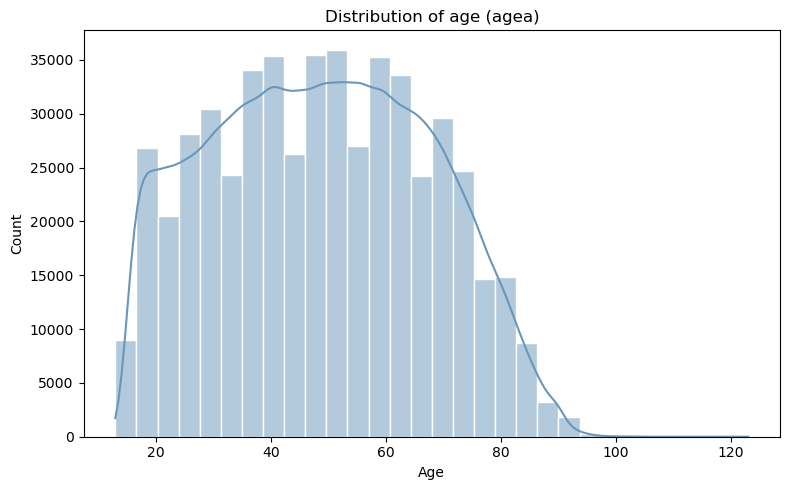

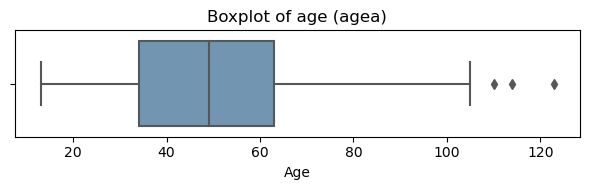

In [32]:
# Inspecting range and potential outliers
print("Min age:", ess_data["agea"].min())
print("Max age:", ess_data["agea"].max())
print("Ages > 100:", (ess_data["agea"] > 100).sum())

# Distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(ess_data["agea"], bins=30, kde=True, color="#6897bb", edgecolor="white")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of age (agea)")
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(6, 2))
sns.boxplot(x=ess_data["agea"], color="#6897bb")
plt.xlabel("Age")
plt.title("Boxplot of age (agea)")
plt.tight_layout()
plt.show()

The age distribution is right-skewed and concentrated between early adulthood and older age. 

A small number of respondents report very high ages (max = 123; 22 cases > 100). Reported ages above 120 are treated as implausible and recoded as missing values, as they exceed realistic human lifespans and are most likely due to reporting or data entry errors.

In [33]:
ess_data.loc[ess_data["agea"] > 120, "agea"] = np.nan

# Verifying that respondents reporting ages higher than 120 were removed
print("Max age:", ess_data["agea"].max())

Max age: 114.0


## 3.2. Target variable distribution and recoding
### Removing rows with missing values in the target variable


In [34]:
ess_data["trstplt"].unique()

array([ 0.,  2.,  4.,  5.,  3.,  6.,  8.,  1., 10.,  7.,  9., nan])

In [35]:
target_trstplt = "trstplt"

ess_data = ess_data.loc[ess_data["trstplt"].notna()]

In [36]:
ess_data["trstplt"].unique()

array([ 0.,  2.,  4.,  5.,  3.,  6.,  8.,  1., 10.,  7.,  9.])

### Checking distribution of the target variable and recoding into categories
The original target variable trstplt measures trust in politicians on an 11-point scale (0-10). We will first explore its distribution

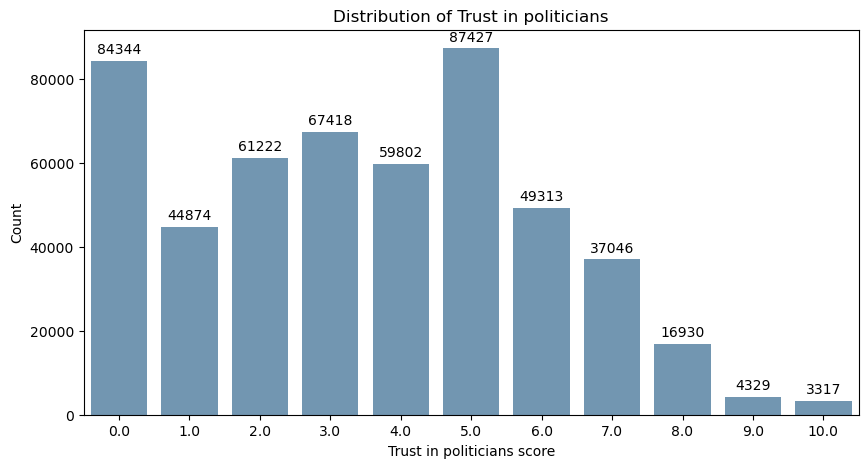

In [37]:
value_count = ess_data["trstplt"].value_counts().sort_index()

plt.figure(figsize=(10, 5))

ax = sns.barplot(
    x=value_count.index,
    y=value_count.values,
    color="#6897bb"
)

plt.title("Distribution of Trust in politicians")
plt.xlabel("Trust in politicians score")
plt.ylabel("Count")

# adding counts on top of bars
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.show()

The distribution shows that several response categories contain relatively few observations and that adjacent values represent very similar levels of trust. Treating the variable as an 11-class outcome would therefore increase class sparsity and model complexity without adding much information.

To address this, we recode the target variable into two broader and more interpretable categories: **low trust (scores 0-4)** and **high trust (scores 5-10)**. This reduces noise as well as improves interpretability and class balance.

In [38]:
def categorize_trust(x):
    if x <= 4:
        return 1 # Low trust
    elif x >= 5:
        return 2 # High trust

ess_data["trstplt"] = ess_data["trstplt"].apply(categorize_trust)

print(ess_data["trstplt"].value_counts().sort_index())

trstplt
1    317660
2    198362
Name: count, dtype: int64


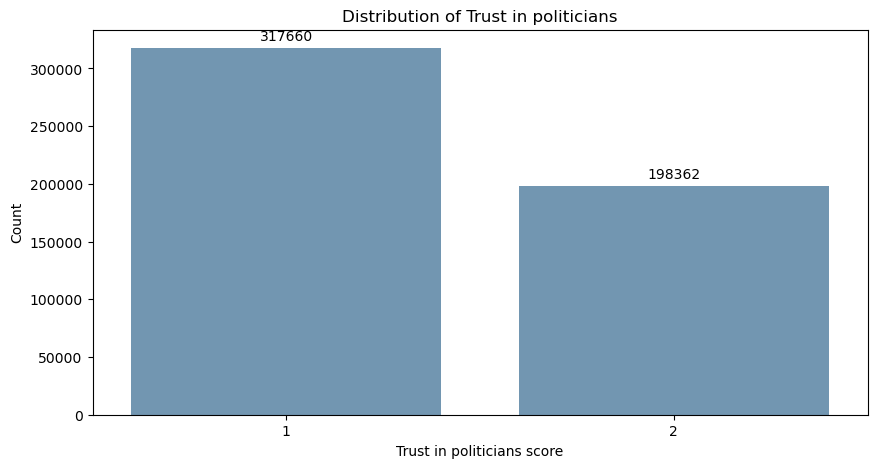

In [71]:
value_count = ess_data["trstplt"].value_counts().sort_index()

plt.figure(figsize=(10, 5))

ax = sns.barplot(
    x=value_count.index,
    y=value_count.values,
    color="#6897bb"
)

plt.title("Distribution of Trust in politicians")
plt.xlabel("Trust in politicians score")
plt.ylabel("Count")

# adding counts on top of bars
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.show()

## 3.3. Checking the percentage of missing values for each variable

In [40]:
n_rows = len(ess_data)
na_counts = ess_data.isnull().sum()

# Proportion of NaNs
na_prop = na_counts / n_rows

print(na_prop.round(2))

agea            0.00
brncntr         0.00
cntry           0.00
ctzcntr         0.00
domicil         0.00
eisced          0.15
essround        0.00
facntr          0.01
gincdif         0.02
gndr            0.00
hincfel         0.02
impfree         0.03
imptrad         0.03
imwbcnt         0.04
ipeqopt         0.03
ipfrule         0.04
ipstrgv         0.04
lrscale         0.14
mocntr          0.00
polintr         0.00
ppltrst         0.00
rlgdgr          0.01
rlgdnm          0.04
stfdem          0.03
stfeco          0.02
stfedu          0.05
stfgov          0.03
stfhlth         0.01
trstplt         0.00
uempla          0.00
uempli          0.00
cntry_region    0.00
dtype: float64


The variables with the most missing values are education level - *"eisced"* (15%) and political ideology - *"lrscale"* (14%). We choose not to remove them and will impute them appropriately along with the rest of the variables after the train and test split.

### Save the full dataset to csv

In [41]:
ess_data.to_csv("ess_final_trstplt.csv", index=False)

# 4. Model setup and preprocessing

## 4.1. Train and test split

In this step, we split the final dataset into training and test subsets. The split is performed using stratification on the target variable *"trstplt"* to ensure that the class distribution is preserved in both sets.

In [42]:
target_variable = "trstplt"

X = ess_data[feature_list]
y = ess_data[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42, stratify=y)

In [43]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Distribution of the target variabble: {y_train.value_counts().sort_index()}")

Train shape: (412817, 30), Test shape: (103205, 30)
Distribution of the target variabble: trstplt
1    254128
2    158689
Name: count, dtype: int64


## 4.2. Creating lists of numerical, ordinal and nominal predictors
Since all variables are stored as numeric values, they cannot be automatically classified as numerical, ordinal, or nominal based on data type alone. To address this, a feature codebook is constructed using SPSS metadata, combining variable labels and value labels for each predictor. We then manually inspect this codebook to correctly classify variables in order to apply appropriate preprocessing steps in the subsequent modeling pipeline.

In [44]:
label_by_variable = (metadata.groupby("variable")["label"].first().to_dict())

value_labels_by_variable = {}

for var, sub in value_labels_dataframe.groupby("variable"):
    code_label_dict = {}

    for _, row in sub.iterrows():
        code = row["code"]
        label = row["value_label"]

        code_str = str(code)
        if code_str not in code_label_dict:
            code_label_dict[code_str] = label

    value_labels_by_variable[var] = code_label_dict
    
rows = []

for var in feature_list:
    rows.append({
        "variable": var,
        "label": label_by_variable.get(var, ""),
        "value_labels": "; ".join(
            [f"{k}: {v}" for k, v in value_labels_by_variable.get(var, {}).items()]
        )
    })

feature_codebook = pd.DataFrame(rows)
feature_codebook.head()

,variable,label,value_labels
0,essround,ESS round,
1,stfeco,How satisfied with present state of economy in...,0.0: Extremely dissatisfied; 1.0: 1; 2.0: 2; 3...
2,stfgov,How satisfied with the national government,0.0: Extremely dissatisfied; 1.0: 1; 2.0: 2; 3...
3,stfdem,How satisfied with the way democracy works in ...,0.0: Extremely dissatisfied; 1.0: 1; 2.0: 2; 3...
4,imwbcnt,Immigrants make country worse or better place ...,0.0: Worse place to live; 1.0: 1; 2.0: 2; 3.0:...


In [45]:
feature_codebook.to_csv("feature_codebook.csv", index=False)

### Classifying variables as numerical, ordinal or nominal

In [46]:
numerical_variables = ["agea"]

ordinal_variables = ["stfeco", "stfgov", "stfdem", "stfhlth", "stfedu", "imwbcnt",
                     "lrscale", "polintr", "gincdif", "ppltrst", "rlgdgr", "eisced",
                     "hincfel", "impfree", "ipstrgv", "ipfrule", "imptrad", "ipeqopt"]

nominal_variables = ["essround", "cntry_region", "domicil", "gndr", "uempla", "uempli",
                    "rlgdnm", "brncntr", "ctzcntr", "facntr", "mocntr"]

Confirming that all variables from feature_list were categorized as numerical, ordinal, or nominal:

In [47]:
len(feature_list)

30

In [48]:
len(numerical_variables) + len(ordinal_variables) + len(nominal_variables)

30

## 4.3 Pipeline for imputing missing values and encoding nominal predictors

In this step, we define preprocessing pipelines that specify how missing values and predictor encoding will be handled for different types of variables. Missing values in numerical and ordinal variables are set to be imputed using the median, while missing values in nominal variables are set to be imputed using the most frequent category with nominal variables subsequently encoded using one-hot encoding. These preprocessing steps are defined here and are applied later within the model pipelines during training to ensure consistent and leakage-free data processing.

In [49]:
numerical_ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

def to_str(X):
    return X.astype(str)

nominal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("to_str", FunctionTransformer(to_str, feature_names_out="one-to-one")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")) # One-Hot-Encoding of nominal variables
])

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_ordinal_transformer, numerical_variables),
        ("ordinal", numerical_ordinal_transformer, ordinal_variables),
        ("nominal", nominal_transformer, nominal_variables),
    ],
    verbose_feature_names_out=False
)

# 5. Machine Learning Models:
Given the imbalance in the target variable, balanced accuracy is used as the primary evaluation metric for all models to ensure that models' performance reflects all classes rather than being dominated by the majority class.

### Tuning setup
To tune models' hyperparameters efficiently, we create a stratified subsample from the training data only. This reduces runtime while preserving the class distribution and keeping the test set untouched for final evaluation.

In [50]:
# Subsamples from training data
X_tune, _, y_tune, _ = train_test_split(
    X_train,
    y_train,
    train_size=100_000,
    random_state=42,
    stratify=y_train
)

print(X_tune.shape, y_tune.shape)

(100000, 30) (100000,)


## 5.1. Decision tree classifier
In this section, we estimate a decision tree classifier to model trust in politicians using the selected ESS predictors, tuning its structure and pruning parameters on a stratified training subsample before refitting the best model on the full training set and evaluating it on the test data.

In [51]:
dt_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

We perform the grid search in two stages to reduce computational cost by first identifying the best performing tree structure and then fine-tuning the pruning strength.
### Stage 1: Tuning tree structure hyperparameters
In this stage, we tune key parameters that control the tree’s structure and complexity using cross-validation and balanced accuracy. The goal is to find a tree that generalizes well without becoming too complex.

In [52]:
dt_param_grid1 = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [3, 4, 5, 6, 8],
    "model__min_samples_split": [0.003, 0.005, 0.01],
    "model__min_samples_leaf": [0.0005, 0.001, 0.002],
    "model__class_weight": [None, "balanced"],
    "model__ccp_alpha": [0.0]
}

grid1 = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=dt_param_grid1,
    cv=3,
    scoring="balanced_accuracy",
    n_jobs=-1,
    verbose=2
)

grid1.fit(X_tune, y_tune)
best_params_stage1 = grid1.best_params_
print("Stage 1 best parameters:", best_params_stage1)
print("Stage 1 average balanced accuracy across 3-fold cross-validation:", grid1.best_score_)


Fitting 3 folds for each of 180 candidates, totalling 540 fits
Stage 1 best parameters: {'model__ccp_alpha': 0.0, 'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__max_depth': 8, 'model__min_samples_leaf': 0.001, 'model__min_samples_split': 0.003}
Stage 1 average balanced accuracy across 3-fold cross-validation: 0.7465008322310694


Balanced accuracy of 0.747 indicates that, on average, the model correctly classifies about 74.7% of observations per class during cross-validation. 

Class_weight="balanced" was selected, which shows that compensating for class imbalance improves performance. 

Gini criterion was chosed as the model criterion. 

Max_depth=8 suggests that a moderately deep tree performs best. 

The selected values min_samples_split = 0.003 and min_samples_leaf = 0.001 mean that a node cab be split only if it contains at least 0.3% of the training samples, and each leaf must contain at least 0.1% of the samples.

### Stage 2: Tuning pruning strength
In the second stage, we keep the best structural settings from tuning the tree structure hyperparameters fixed and tune only ccp_alpha, which controls cost-complexity pruning. This may help in reducing overfitting by removing branches that contribute little to predictive performance.

In [53]:
dt_stage2 = clone(dt_pipeline)

# Using the best structure parameters from stage 1 except for cpp_alpha
dt_stage2.set_params(**{k: v for k, v in best_params_stage1.items() if k != "model__ccp_alpha"})

dt_param_grid2 = {"model__ccp_alpha": [0.0, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3]}

grid2 = GridSearchCV(
    estimator=dt_stage2,
    param_grid=dt_param_grid2,
    cv=3,
    scoring="balanced_accuracy",
    n_jobs=-1,
    verbose=2
)

grid2.fit(X_tune, y_tune)
best_params_stage2 = grid2.best_params_
print("Stage 2 best parameters:", best_params_stage2)
print("Stage 2 average balanced accuracy across 3-fold cross-validation:", grid2.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Stage 2 best parameters: {'model__ccp_alpha': 5e-05}
Stage 2 average balanced accuracy across 3-fold cross-validation: 0.7466036953673575


The optimal pruning strength is ccp_alpha = 5e-05. It leads to only a small improvement in cross-validated balanced accuracy compared to no pruning, suggesting that mild pruning improves generalization but not substantially.

### Refitting the best model on the full training set
Using the best hyperparameters from both tuning stages, we refit the final decision tree pipeline on the entire training set to maximize learning before evaluating once on the test set.

In [54]:
final_params = best_params_stage1.copy()
final_params.update(best_params_stage2) # Adding best ccp_alpha to final_params

best_dt = clone(dt_pipeline).set_params(**final_params)

best_dt.fit(X_train, y_train) # Fitting the model on the full training set
y_pred_dt = best_dt.predict(X_test) # Evaluating on the test set

### Evaluating on the test set - balanced accuracy and classification report
Here, we evaluate out-of-sample performance using balanced accuracy and a classification report.

In [55]:
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt, digits=3))

Balanced accuracy: 0.7456146824377938
              precision    recall  f1-score   support

           1      0.827     0.738     0.780     63532
           2      0.642     0.753     0.693     39673

    accuracy                          0.744    103205
   macro avg      0.735     0.746     0.737    103205
weighted avg      0.756     0.744     0.747    103205



The decision tree achieves a balanced accuracy of 0.746 which is very close to the cross-validation results, indicating that it performs similarly well across both trust categories despite class imbalance. 

Class-level results show balanced recall for low trust and high trust respondents (0.738 and 0.753, respectively), while precision is higher for low trust (0.827) than for high trust (0.642), leading to stronger overall F1-performance for the low trust class. 

Overall accuracy (0.744) aligns closely with the macro-averaged and weighted metrics, confirming that that overall model performance is stable and that no class is systematically ignored.

## 5.2. Random forest classifier
In this section, we build on the single-tree approach by training a random forest classifier, which aggregates many decision trees built on bootstrapped samples, with hyperparameters tuned on a stratified training subsample and the final model refit on the full training set before test evaluation.

In [56]:
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        random_state=42,
        n_jobs=1, # Setting n_jobs as 1 to prevent nested parallelism since we are parallelizing CV
        bootstrap=True
    ))
])

### Tuning hyperparameters

In [57]:
rf_param_grid = {
    "model__n_estimators": [200, 300, 500, 800],
    "model__max_depth": [8, 12, 15, 18, None],
    "model__min_samples_split": [0.0002, 0.0005, 0.001, 0.002, 0.005],
    "model__min_samples_leaf": [0.0001, 0.0002, 0.0005, 0.001, 0.002],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5,],
    "model__max_samples": [0.5, 0.6, 0.7, 0.8],
    "model__class_weight": ["balanced_subsample", "balanced", None],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_grid,
    n_iter=80, 
    scoring="balanced_accuracy",
    cv=cv,
    verbose=2,
    n_jobs=-1, # Parallelizing CV
    random_state=42
)

rf_search.fit(X_tune, y_tune)

print("Best parameters:")
print(rf_search.best_params_)
print("Average balanced accuracy across 3-fold cross-validation:", rf_search.best_score_)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best parameters:
{'model__n_estimators': 500, 'model__min_samples_split': 0.0005, 'model__min_samples_leaf': 0.0002, 'model__max_samples': 0.5, 'model__max_features': 0.5, 'model__max_depth': 15, 'model__class_weight': 'balanced_subsample'}
Average balanced accuracy across 3-fold cross-validation: 0.758107524359359


Balanced accuracy of 0.758 indicates that, on average, the model correctly classifies about 75.8% of observations per class during cross-validation.

The randomized search identifies a random forest with 500 trees and no maximum depth constraint (max_depth = None), indicating that deep individual trees can be effective when their predictions are averaged across a large ensemble.

The selected values min_samples_split = 0.001 and min_samples_leaf = 0.0002 imply that splits and terminal nodes are allowed with very small proportions of the training data, suggesting that the model benefits from capturing detailed patterns rather than heavily restricting tree growth.

The choice of max_samples = 0.5 and max_features = 0.5 shows that randomly subsampling both observations and features increases diversity among trees, which helps reduce variance and improves generalization.

In addition, class_weight = "balanced_subsample" was selected, which means that class imbalance is corrected separately within each bootstrap sample, allowing individual trees to adapt to local class distributions. This indicates that in our case adjusting for class imbalance within each bootstrap sample improves balanced accuracy.

### Refitting the best model on the full training set
Using the best hyperparameters from both tuning stages, we refit the final random forest pipeline on the entire training set to maximize learning before evaluating once on the test set.

In [58]:
best_rf = rf_search.best_estimator_
best_rf.fit(X_train, y_train)  # Fitting the model on the full training set
y_pred_rf = best_rf.predict(X_test) # Evaluating on the test set

### Evaluating on the test set - balanced accuracy and classification report
Here, we evaluate out-of-sample performance using balanced accuracy and a classification report.

In [59]:
print("Balanced_accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print("Classification report:\n")
print(classification_report(y_test, y_pred_rf, digits=3))

Balanced_accuracy: 0.7552587784236429
Classification report:

              precision    recall  f1-score   support

           1      0.834     0.750     0.790     63532
           2      0.655     0.761     0.704     39673

    accuracy                          0.754    103205
   macro avg      0.744     0.755     0.747    103205
weighted avg      0.765     0.754     0.757    103205



On the test set, the random forest achieves a balanced accuracy of 0.755, which is very close to the cross-validated score and indicates good generalization and no evidence of overfitting.

Recall is well balanced across classes (0.750 for low trust and 0.761 for high trust), while precision remains higher for the low trust class (0.834 for low trust and 0.655 for high trust), resulting in stronger F1-performance for the first group.

Overall accuracy (0.754), together with similar macro-averaged and weighted metrics, confirms that the model performs consistently across both trust categories and achieves slightly higher predictive performance than the single decision tree.

## 5.3. Gradient boosting classifier
In this section, we train a gradient boosting classifier that sequentially builds an ensemble of shallow decision trees to correct previous errors, tuning learning and tree-complexity parameters on a stratified training subsample before refitting the optimal model on the full training set and evaluating it on the test data.

In [60]:
gb_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

### Tuning hyperparameters

In [61]:
gb_param_grid = {
    "model__max_depth": [2, 3],
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__n_estimators": [100, 200, 400],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__min_samples_split": [0.0002, 0.0005, 0.001, 0.003, 0.005],
    "model__min_samples_leaf": [0.0001, 0.0002, 0.0005, 0.001, 0.002],
    "model__max_features": ["sqrt", "log2", None]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

gb_search = RandomizedSearchCV(
    estimator=gb_pipeline,
    param_distributions=gb_param_grid,
    n_iter=80,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

gb_search.fit(X_tune, y_tune)

print("Best parameters:", gb_search.best_params_)
print("Average balanced accuracy across 3-fold cross-validation:", gb_search.best_score_)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best parameters: {'model__subsample': 1.0, 'model__n_estimators': 400, 'model__min_samples_split': 0.0005, 'model__min_samples_leaf': 0.0005, 'model__max_features': 'log2', 'model__max_depth': 3, 'model__learning_rate': 0.1}
Average balanced accuracy across 3-fold cross-validation: 0.7497585823206924


Balanced accuracy of 0.750 indicates that, on average, the model correctly classifies about 75.0% of observations per class during 3-fold cross-validation.

The randomized search selects max_depth = 3 with n_estimators = 400, meaning the model performs best with many shallow-to-moderately deep boosting stages rather than a few strong trees.

The choice of learning_rate = 0.1 suggests the model benefits from moderately sized boosting updates while still relying on a relatively large number of trees.

The selected subsample = 1.0 and max_features = 'log2' means the best-performing configuration uses all training observations and a random subsample of features at each boosting stage.

Finally, min_samples_split = 0.0005 and min_samples_leaf = 0.0005 mean that a node is split only if it contains at least 0.05% of the training samples, and each leaf must contain at least 0.05% of the samples, which provides mild regularization while still allowing fairly detailed splits.

### Refitting the best model on the full training set
Using the best hyperparameters from both tuning stages, we refit the final Gradient boosting pipeline on the entire training set to maximize learning before evaluating once on the test set.

In [62]:
best_gb = gb_search.best_estimator_
best_gb.fit(X_train, y_train)
y_pred_gb = best_gb.predict(X_test)

### Evaluating on the test set - balanced accuracy and classification report
Here we evaluate out-of-sample performance using balanced accuracy and a classification report.

In [63]:
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb, digits=3))

Balanced accuracy: 0.7478527033579789
              precision    recall  f1-score   support

           1      0.795     0.844     0.819     63532
           2      0.723     0.651     0.685     39673

    accuracy                          0.770    103205
   macro avg      0.759     0.748     0.752    103205
weighted avg      0.767     0.770     0.768    103205



On the test set, the gradient boosting model reaches a balanced accuracy of 0.748, which is close to the cross-validated score (0.750) and indicates reasonable generalization and no evidence of overfitting.

Class-level performance shows higher recall for low trust (0.844) but lower recall for high trust (0.651), meaning the model is better at finding low trust respondents but misses a larger share of high-trust cases.

Precision is higher for low trust (0.795) than for high trust (0.723), and the F1-score reflects this difference (0.819 for low trust and 0.685 for high trust), showing the model is more reliable overall for the low trust class.

Although overall accuracy is 0.770, the balanced accuracy is lower because performance is uneven across classes - this helps explain why the model is weaker than random forest for your goal of balanced class performance.

# 6. Model evaluation and comparison

In [64]:
# Defining a custom colormap
soft_blue = LinearSegmentedColormap.from_list(
    "soft_blue",
    ["#f2f7fb", "#cfe0ef", "#9bbdd8", "#6897bb"]
)

## 6.1. Model performance comparison table

In [65]:
rows = []
for name, y_pred in [
    ("Decision tree", y_pred_dt),
    ("Random forest", y_pred_rf),
    ("Gradient boosting", y_pred_gb),
]:
    bacc = balanced_accuracy_score(y_test, y_pred)
    acc  = accuracy_score(y_test, y_pred)

    # per-class metrics for both classes
    prec, rec, f1, sup = precision_recall_fscore_support(y_test, y_pred, labels=[1,2], zero_division=0)

    rows.append({
        "model": name,
        "balanced_accuracy": bacc,
        "accuracy": acc,
        "precision_class1": prec[0], "precision_class2": prec[1],
        "recall_class1": rec[0], "recall_class2": rec[1],
        "f1_class1": f1[0], "f1_class2": f1[1],
    })

metrics_results = pd.DataFrame(rows).sort_values("balanced_accuracy", ascending=False)

num_cols = metrics_results.select_dtypes(include="number").columns

display(
    metrics_results
    .style
    .set_caption("Model performance comparison on the test set")
    .set_table_styles([
          {"selector": "caption",
            "props": [
                ("caption-side", "top"),
                ("font-size", "14px"),
                ("font-weight", "bold"),
                ("text-align", "center"),
                ("padding", "10px")
            ]
          }
    ])
    .format({c: "{:.3f}" for c in num_cols})
    .background_gradient(cmap=soft_blue, subset=num_cols)
)

,model,balanced_accuracy,accuracy,precision_class1,precision_class2,recall_class1,recall_class2,f1_class1,f1_class2
1,Random forest,0.755,0.754,0.834,0.655,0.750,0.761,0.790,0.704
2,Gradient boosting,0.748,0.770,0.795,0.723,0.844,0.651,0.819,0.685
0,Decision tree,0.746,0.744,0.827,0.642,0.738,0.753,0.780,0.693


The metrics table shows that random rorest achieves the highest balanced accuracy (0.755), slightly outperforming gradient boosting (0.748) and the decision tree (0.746). This indicates that random forest provides the most even performance across low trust and high trust respondents, which is the primary evaluation goal in the case of class imbalance. Although gradient boosting reaches the highest overall accuracy (0.770), its lower balanced accuracy reflects uneven class performance, with substantially higher recall for low trust than for high trust. Random forest exhibits the most balanced recall across classes (0.750 vs. 0.761), resulting in more similar F1-scores for both classes and more consistent classification overall. Across all models, precision is higher for the low trust class, indicating that predictions of low trust are generally more reliable than predictions of high trust.

## 6.2. Confusion matrices

Normalized confusion matrices are used in the evaluation since they are more appropriate for comparing models under class imbalance that raw confusion matrices.

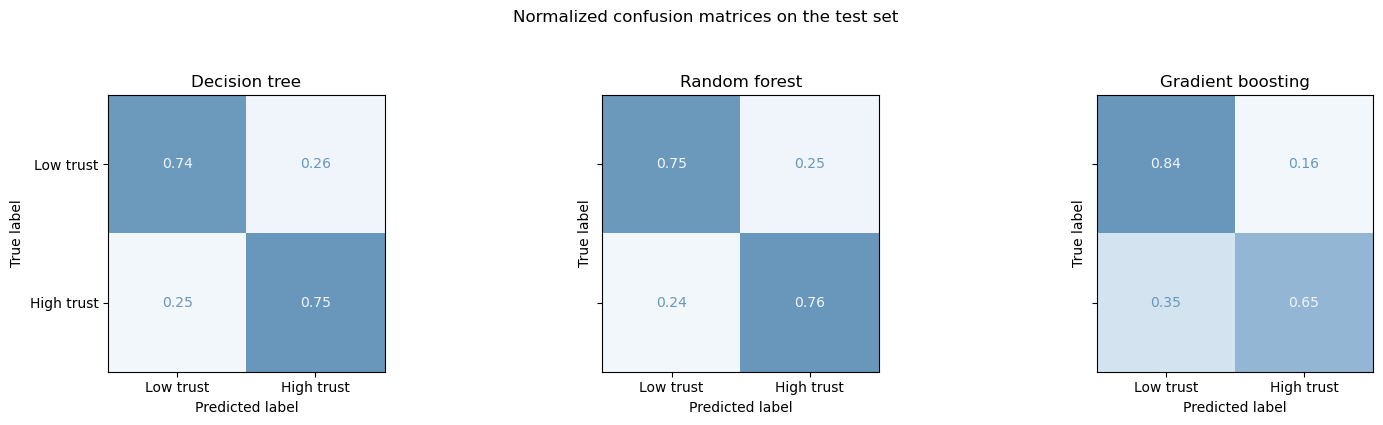

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)

labels = [1, 2]
label_names = ["Low trust", "High trust"]

for ax, (name, y_pred) in zip(
    axes,
    [("Decision tree", y_pred_dt), ("Random forest", y_pred_rf), ("Gradient boosting", y_pred_gb)]
):
    cm = confusion_matrix(y_test, y_pred, labels=[1, 2], normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(ax=ax, values_format=".2f", cmap=soft_blue, colorbar=False)
    ax.set_title(name)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.suptitle("Normalized confusion matrices on the test set", y=1.05)
plt.tight_layout()
plt.show()

The normalized confusion matrices highlight differences in how models distribute errors across classes. Random forest shows the most balanced classification, correctly identifying about 75% of both low trust and high trust respondents. The decision tree performs slightly worse but follows the same pattern. In contrast, gradient boosting strongly favors the low trust class, achieving high recall for low trust but substantially lower recall for high trust. This explains why gradient boosting’s balanced accuracy is lower despite its strong overall accuracy.

## 6.3. Error analysis

In [67]:
results = []

for name, y_pred in [
    ("Decision tree", y_pred_dt),
    ("Random forest", y_pred_rf),
    ("Gradient boosting", y_pred_gb)
]:
    cm = confusion_matrix(y_test, y_pred, labels=[1, 2])

    tn, fp, fn, tp = cm.ravel()

    results.append({
        "Model": name,
        "True Negatives (Low trust correctly classified)": tn,
        "False Positives (Low trust misclassified)": fp,
        "False Negatives (High trust misclassified)": fn,
        "True Positives (High trust correctly classified)": tp
    })

error_analysis = pd.DataFrame(results)
display(error_analysis
        .style
        .set_caption("Error analysis")
        .set_table_styles([
          {"selector": "caption",
            "props": [
                ("caption-side", "top"),
                ("font-size", "14px"),
                ("font-weight", "bold"),
                ("text-align", "center"),
                ("padding", "10px")
            ]
          }
        ]))

,Model,True Negatives (Low trust correctly classified),False Positives (Low trust misclassified),False Negatives (High trust misclassified),True Positives (High trust correctly classified)
0,Decision tree,46880,16652,9786,29887
1,Random forest,47625,15907,9486,30187
2,Gradient boosting,53642,9890,13831,25842


The error analysis clarifies the practical consequences of the model choice. Random forest produces the lowest number of false negatives (9486) among the three models, meaning it is the most effective at correctly identifying high trust respondents and least likely to incorrectly label them as low trust. This is particularly important as false negatives correspond to underestimating trust in politicians, which could bias conclusions toward excessive political distrust.

Gradient boosting, by contrast, has the highest number of false negatives (13831), confirming that it systematically misses a big share of high trust respondents. However, it produces the fewest false positives (9890) when compared to the other models, meaning it is the most conservative model when assigning high trust. This makes gradient boosting preferable in contexts where overstating trust is considered more problematic than understating it.

The decision tree lies between the two ensemble models but has higher false positives and false negatives than the random forest. 

Overall, random forest provides the best balance between minimizing both types of error, making it the most suitable model when both misclassification costs are considered equally important.

## 6.4. Feature importance
Feature importance is visualized in two ways - first at the level of all final model inputs, including dummy variables created through one-hot encoding, and second in an aggregated form where dummy variables are recombined to reflect the importance of the original predictors.

In [68]:
# feature importance functions
def get_feature_importance(pipeline):
    model = pipeline.named_steps["model"]
    feature_names = pipeline.named_steps["preprocess"].get_feature_names_out()
    return (
        pd.DataFrame({
            "Feature": feature_names,
            "Importance": model.feature_importances_
        })
        .sort_values("Importance", ascending=False)
        .reset_index(drop=True)
    )

original_vars = list(feature_list)

def base_var(col):
    if col in original_vars:
        return col
    matches = [v for v in original_vars if col.startswith(v + "_")]
    return max(matches, key=len) if matches else col


### Feature importance including dummy variables

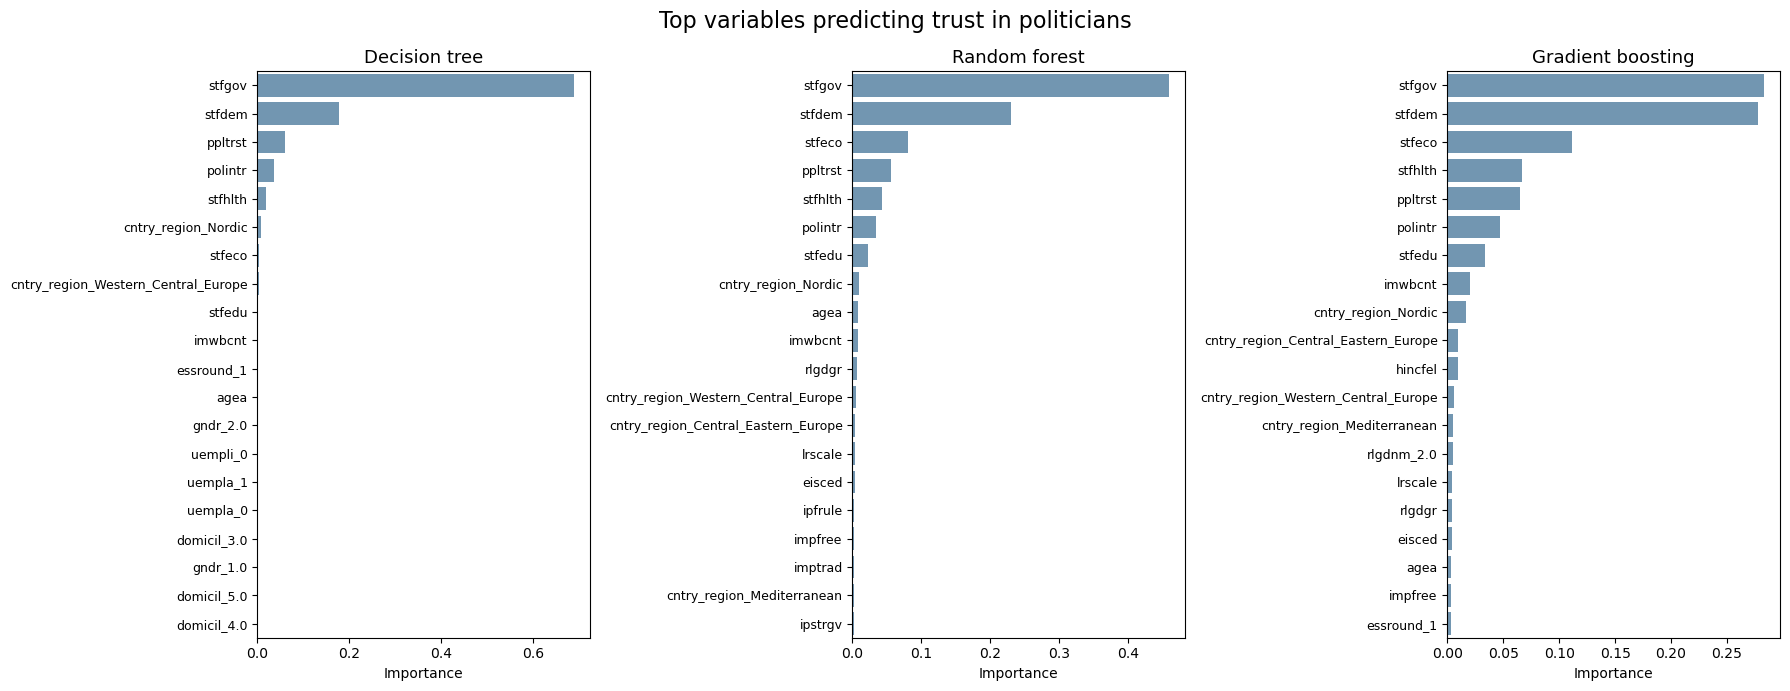

In [69]:
top_k = 20
models = {
    "Decision tree": best_dt,
    "Random forest": best_rf,
    "Gradient boosting": best_gb
}

fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharex=False)

for ax, (name, pipe) in zip(axes, models.items()):
    fi = get_feature_importance(pipe).head(top_k)

    sns.barplot(
        data=fi,
        x="Importance",
        y="Feature",
        color="#6897bb",
        ax=ax
    )

    ax.set_title(name, fontsize=13)
    ax.set_xlabel("Importance")
    ax.set_ylabel("")
    ax.tick_params(axis="y", labelsize=9)

plt.suptitle("Top variables predicting trust in politicians", fontsize=16)
plt.tight_layout()
plt.show()

The feature importance plots show that all three models strongly agree on the dominance of political satisfaction variables, particularly satisfaction with government (*"stfgov"*) and satisfaction with democracy (*"stfdem"*). In the decision tree, stfgov alone accounts for a very large share of total importance, indicating a highly concentrated decision structure. In contrast, 

Random forest and gradient boosting distribute importance across more predictors, including satisfaction with the economy (*"stfeco"*), interpersonal trust (*"ppltrst"*), political interest (*"polintr"*), and evaluations of public services: health services (*"stfhlth"*) and education (*"stfedu"*). 

Regional context dummy variables (*"cntry_region_{}"*) also appear as important features but it is more noticeable in the ensemble models, especially in gradient boosting. The top region for predicting trust in politicians is the Nordic Region with Western-Central and Central-Eastern Europe following closely behind for ensamble models.

This broader variable choice reflects the ensembles’ ability to capture more complex and additive relationships between predictors and political trust.

### Aggregated feature importance
We also create an aggregated feature importance plot which aggregates dummy columns for nominal variables and shows the most important features.

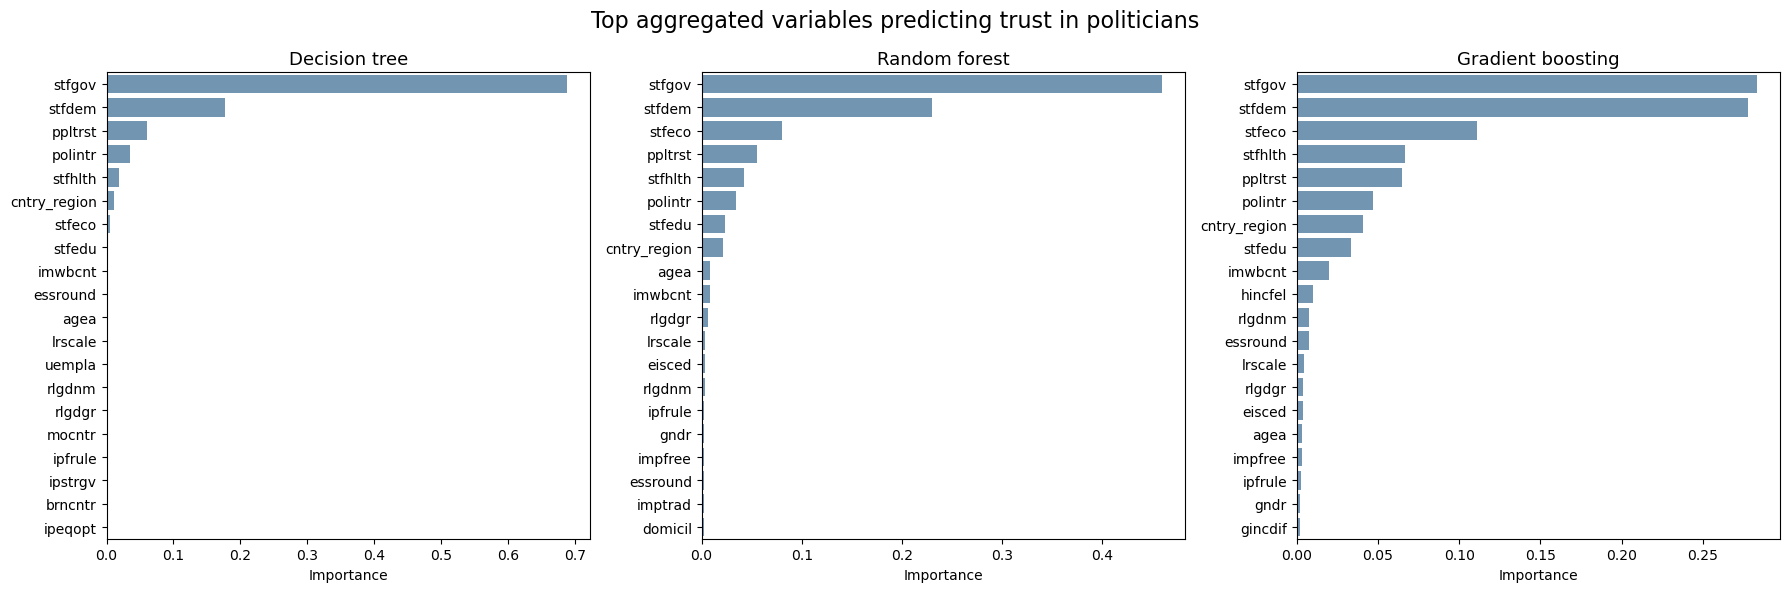

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False)

for ax, (name, pipe) in zip(axes, models.items()):
    fi = get_feature_importance(pipe)

    var = (
        fi
        .assign(Variable=fi["Feature"].apply(base_var))
        .groupby("Variable", as_index=False)["Importance"]
        .sum()
        .sort_values("Importance", ascending=False)
        .head(top_k)
    )

    sns.barplot(
        data=var,
        x="Importance",
        y="Variable",
        color="#6897bb",
        ax=ax
    )

    ax.set_title(name, fontsize=13)
    ax.set_xlabel("Importance")
    ax.set_ylabel("")
    ax.tick_params(axis="y", labelsize=10)

plt.suptitle("Top aggregated variables predicting trust in politicians", fontsize=16)
plt.tight_layout()
plt.show()

When aggregating dummy variables back to their original features, the substantive interpretation becomes even clearer. Across all models, evaluations of political performance (*"stfgov"*) and democratic functioning (*"stfdem"*) appear as the strongest predictors of trust in politicians, far outweighing socio-demographic characteristics such as age (*"agea"*), gender (*"gndr"*), or education (*"eisced"*) and attitudes toward imigrants (*"imwbcnt"*) as well as religiousity (*"rlgdgr"*). Regional context (*"cntry_region"*) plays a secondary but non-negligible role, particularly in the ensemble models, suggesting systematic cross-national differences in trust levels. 

The consistency of these patterns across models strengthens confidence in the robustness of the findings and supports the theoretical expectation that political trust is driven primarily by citizens' perceptions on institutional performance rather than individual background characteristics.

# 7. Comparison of empirical results with the literature
The empirical findings of this project are largely consistent with the existing literature on political trust. Across all three models, evaluations of political performance - satisfaction with government (*"stfgov"*) and satisfaction with democracy (*"stfdem"*) - and the economy (*"stfeco"*) show up as the strongest predictors of trust in politicians. This closely aligns with prior research identifying these factors as the central drivers of political trust (Christensen & Lægreid, 2005; Weber et al., 2017).

Variables related to the perception of the state of public health and education services (*"stfhlth"*, *"stfedu"*) also appear among the most important predictors in the ensemble models, supporting findings by Murtin et al. (2018) that trust in government is linked to citizens’ evaluations of service performance. Similarly, interpersonal trust (*"ppltrst"*) and political interest (*"polintr"*) contribute meaningfully to predictions, which is consistent with the research conducted by Mingo and Faggiano (2020) as well as Christensen and Lægreid (2005).

The presence of regional effects (*"cntry_region"*) among the more important predictors in the ensemble models is consistent with our initial belief that there are systematic differences in political trust across different regions. 

In contrast, socio-demographic characteristics such as age, gender, and education show relatively low importance once political attitudes and performance evaluations are accounted for. While previous studies have identified these factors as relevant correlates of political trust (Melios, 2020; Christensen & Lægreid, 2005), our results suggest that their influence is secondary to citizens’ direct assessments of political institutions. 
Attitudes toward immigrants (*"imwbcnt"*), religiosity (*"rlgdgr"*, *"rlgdnm"*) and human values related to self-direction, conformity, and tradition (*"impfree"*, *"ipfrule"*, *"imptrad"*, *"ipstrgv"*) also appear only marginally important in the models which only partially aligns with the literature. These factors have some prediction strength, however the effect is not major while the literature usually treats them as such. (Devos et al., 2002; Morselli et al., 2015, Mingo & Faggiano, 2020).
This supports the thesis that political trust is shaped more by perceived institutional quality than by individual background characteristics.

# 8. Summary and conclusions
The results show that random forest is the best-performing model overall. It achieves the highest balanced accuracy, maintains stable recall across both trust categories, and minimizes both false positives and false negatives. Gradient boosting performs well when the priority is accurately identifying low trust respondents and avoiding false claims of high trust, but it does so at the expense of missing many genuinely high trust cases. The decision tree offers interpretability but is consistently outperformed by the ensemble methods. Given our project’s emphasis on balanced classification and careful error control, random forest represents the most appropriate and reliable model for predicting trust in politicians in this setting.

Overall, there is strong alignment between the model-based results and the literature which strengthens our confidence in both the variable selection strategy, the models' performance, and the interpretation of the findings.

## 8.1. Ethical considerations

Since our project models people's political attitudes and social characteristics, it is important to consider how the results may be interpreted or potentially misused.

The predicted target variable, trust in politicians, is a subjective perception that depends on social, political, and cultural context. Therefore, the models capture statistical patterns present in the data rather than any objective assessment of political trust. Differences in predictions across groups may therefore reflect broader structural inequalities or contextual factors instead of characteristics of individuals.

In addition, the analysis relies exclusively on ESS data which contains only individual-level survey responses and does not incorporate macroeconomic or institutional indicators such as GDP growth, unemployment rates, inflation, or government perfermance metrics such as the corruption index. These contextual factors play an important role in shaping political trust and their absence may limit the explanatory scope of the models. Therefore, the results should be interpreted as reflecting individual perceptions rather than a full overview of the broader economic and political conditions that influence trust in politicians.

Several predictors used in the analysis, such as gender, migration status and background or religion, can be considered sensitive attributes. Despite our best efforts models may reroduce existing disparities found in the data. To mitigate that risk, we evaluated models based on balanced accuracy and class-level performance to ensure that predictive performance is not driven solely by the majority class and that errors are analyzed for both trust categories.

The results of this project are intended only for academic and analytical purposes. The models are not designed for individual-level decision-making, profiling, or targetting, and using them in these context would be inappropriate. Therefore, findings should be interpreted at an aggregated level and uncertainty and limitations should be communicated clearly.

Finally, the selection of explanatory variables is grouded in literature and does not stem from personal analysis as the complexity of harmonizing variables across multiple ESS rounds required restricting the feature set to a small subset. This means that some relevant predictors may have been ommitted, and the results of our projecr should be understood as indicative, rather than exhaustive.

# 9. Bibliography
1. Bobzien, L. (2023). Income inequality and political trust: Do fairness perceptions matter? Social Indicators Research, 169, 505–528. https://doi.org/10.1007/s11205-023-03168-9

2. Christensen, T., & Lægreid, P. (2005). Trust in Government: The Relative Importance of Service Satisfaction, Political Factors, and Demography. Public Performance & Management Review, 28(4), 487–511. http://www.jstor.org/stable/3381308

3. Devos, T., Spini, D., & Schwartz, S. H. (2002). Conflicts among human values and trust in institutions. British Journal of Social Psychology, 41(4), 481–494.

4. European Social Survey (ESS). (n.d.). European Social Survey Round 1–11 Data (Data file and documentation). Sikt – Norwegian Agency for Shared Services in Education and Research. Retrieved October 2025, from https://ess.sikt.no/en/

5. Melios, G. (2020). Europe in crisis: Political trust, corruption and austerity. SSRN. http://dx.doi.org/10.2139/ssrn.3847633

6. Mingo, I., & Faggiano, M. P. (2020). Trust in institutions between objective and subjective determinants: A multilevel analysis in European countries. Social Indicators Research, 151, 815–839. https://doi.org/10.1007/s11205-020-02400-0

7. Morselli, D., Spini, D., & Devos, T. (2015). Trust in institutions and human values in the European context: A comparison between the World Value Survey and the European Social Survey. Psicologia sociale, 2015(3), 209–222. https://doi.org/10.1482/81369

8. Murtin, F., Fleischer, L., Siegerink, V., Aassve, A., Algan, Y., Boarini, R., Gonzalez, S., Lonti, Z., Schmidt, U., Grimalda, G., Vallve, R. H., Kim, S., Lee, D., Putterman, L., & Smith, C. (2018). Trust and its determinants: Evidence from the Trustlab experiment (OECD Statistics Working Paper No. 89; SDD/DOC(2018)2),,. Organisation for Economic Co-operation and Development. https://hal.science/hal-03596480.

9. OpenAI. (2025). ChatGPT (GPT-5.2) [Large language model]. https://chat.openai.com/chat *

10. Röder, A., & Mühlau, P. (2011). Discrimination, exclusion and immigrants' confidence in public institutions in Europe. European Societies, 13(4), 535–557. https://doi.org/10.1080/14616696.2011.597869

11. Weber, P., Steinmetz, H., & Kabst, R. (2017). Trust in Politicians and Satisfaction with Government – A Reciprocal Causation Approach for European Countries. Journal of Civil Society. https://doi.org/10.1080/17448689.2017.1385160

*Used as support for "Reading SPSS files and extracting variable- and value- label metadata"